In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm

In [2]:
from scipy.stats import pearsonr,spearmanr
from gplearn.genetic import SymbolicRegressor,SymbolicTransformer
from gplearn import fitness
from gplearn.functions import make_function
from gplearn.fitness import make_fitness

In [3]:
feature = pd.read_pickle('/home/wangs/data/check/all_status.pk').loc['20200104':'20230101']
fields = list(feature.columns)
feature = feature.rank()/feature.count()
feature['test_date'] = feature.index
test_date = feature.index

In [4]:
function_set = ['add','sub','mul','div','sqrt','log','inv','abs','neg']

In [5]:
close_ = ff.read('close').loc[:,'20210104':'20230101']
ret = (close_ - close_.shift(axis = 1))/close_.shift(axis = 1)
event = ff.read('Gpalpha014').loc[:,'20210104':'20230101']

In [6]:
import statsmodels.api as sm
def open_day_matrix(y,y_pred,w=None):
    best_rate = []
    if len(np.unique(y_pred))<=2:
        return 0
    else:
        data=pd.DataFrame({'y_pred':y_pred,'date':test_date})
        ts = pd.Series(data.loc[:,'y_pred'].values,index = data['date'])
        # for day_len in [5,10,20,50,100]:
        #     open_day = ((ts > ts.rolling(day_len,closed = 'left').quantile(2/3)).loc['20210104':'20230101']).replace({True:1.0,False:0})
        #     ret_all = []
        #     for day in event.columns:
        #         buy_stock =  (event*ff.filter1.loc[:,'20210104':'20230101'])[day].dropna().sort_values().head(20).index
        #         ret_all.append(ret.shift(-1,axis = 1).loc[buy_stock][day].mean())
        #     ret_all[-1] = 0.0
        #     best_rate.append(ff.cal_returns(ret_all * open_day.loc['20210104':'20230101'])['收益回撤比'])
        # return np.max(best_rate)
        open_day = ((ts < ts.rolling(5,closed = 'left').quantile(1/2)).loc['20210104':'20230101']).replace({True:1.0,False:0})
        # open_day = ((ts < ts.quantile(1/2)).loc['20210104':'20230101']).replace({True:1.0,False:0})
        if (open_day.sum() == 0):
            return 0
        ret_all = []
        for day in event.columns:
            buy_stock =  (event*ff.filter1.loc[:,'20210104':'20230101'])[day].dropna().sort_values().head(20).index
            ret_all.append(ret.shift(-1,axis = 1).loc[buy_stock][day].mean())
        ret_all[-1] = 0.0
        return ff.cal_returns(ret_all * open_day)['收益回撤比']

In [7]:
open_day_fc=make_fitness(function=open_day_matrix,greater_is_better=True)

In [8]:
test_gp=SymbolicTransformer(feature_names = fields,
                            function_set = function_set, #所有算子
                            generations = 4, #进化代数
                            population_size = 500, #种群规模
                            tournament_size = 10, #竞标赛规模
                            p_crossover=0.4,
                            p_subtree_mutation=0.05,
                            p_hoist_mutation=0.01,
                            p_point_mutation=0.03,
                            p_point_replace=0.35,
                            init_depth=(1,4),
                            const_range = None,
                            metric=open_day_fc,
                            parsimony_coefficient = 'auto',
                            low_memory=True,
                            verbose=2,
                            n_jobs = 6,
                           stopping_criteria=30.0)

In [9]:
test_gp.fit(np.nan_to_num(feature.loc[:,fields].values),pd.Series(0,feature.index).values)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed: 21.9min remaining: 43.7min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed: 22.9min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


   0     4.53          1.34395        3          5.12555              N/A     68.76m


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed: 21.3min remaining: 42.7min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed: 23.1min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


   1     5.17          2.33803       10          6.64971              N/A     46.15m


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed: 26.5min remaining: 53.0min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed: 27.9min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


   2     5.33          3.31177       18          8.51713              N/A     27.88m


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed: 24.1min remaining: 48.2min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed: 24.4min finished


   3     4.80          4.25318       18          8.51713              N/A      0.00s


SymbolicTransformer(const_range=None,
                    feature_names=['PB', 'PE', 'std_type_raw', 'ILQ_type_raw',
                                   'std_type', 'ILQ_type', 'high5_rate',
                                   'high20_rate', 'high60_rate', 'high240_rate',
                                   'low5_rate', 'low20_rate', 'low60_rate',
                                   'low240_rate', 'amount_vol', 'circ_mv_vol',
                                   'turnover_rate_vol', 'turnover_rate_f_vol',
                                   'percentile60_mean', 'percentile60_median',
                                   'percentile60_ske...
                    function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'inv', 'abs', 'neg'],
                    generations=4, init_depth=(1, 4), low_memory=True,
                    metric=<gplearn.fitness._Fitness object at 0x7f97f30f48b0>,
                    n_jobs=6, p_crossover=0.4, p_point_mutation=0.03,
                    p_point_replace=0.35, p_subtree_mutation=0.05,
                    parsimony_coefficient='auto', population_size=500,
                    stopping_criteria=30.0, tournament_size=10, verbose=2)

In [10]:
feature_2 = pd.read_pickle('/home/wangs/data/check/all_status.pk').loc['20200104':'20230101']
fields = list(feature_2.columns)
feature_2 = feature_2.rank()/feature_2.count()

Program 1: log(sub(neg(mul(high20_rate, percentile240_skew)), sub(mul(sqrt(div(inv(amount60), log(amount120))), sqrt(turnover_rate_f_vol)), neg(low60_rate))))
Program 2: log(sub(div(PE, amount20), sub(div(high240_rate, profit_20), neg(low60_rate))))
Program 3: log(sub(neg(percentile120_median), sub(div(high240_rate, profit_20), neg(low60_rate))))
Program 4: sub(div(high240_rate, profit_20), neg(low60_rate))
Program 5: log(sub(neg(inv(inv(low240_rate))), sub(div(high240_rate, profit_20), neg(low60_rate))))
Program 6: log(sub(neg(mul(high20_rate, profit_240)), add(mul(high240_rate, profit_20), neg(low60_rate))))
Program 7: inv(sub(neg(sqrt(mul(down_rate, high5_rate))), sub(div(high240_rate, profit_20), neg(low60_rate))))
Program 8: abs(low240_rate)
Program 9: inv(neg(low240_rate))
Program 10: log(neg(low240_rate))


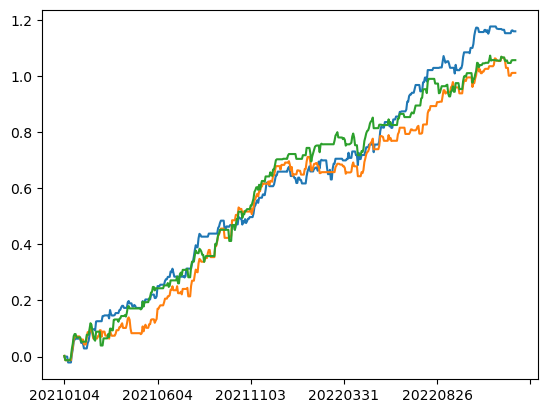

In [11]:
for i, program in enumerate(test_gp._best_programs):
    print(f'Program {i+1}: {program}')
    transform_X = program.execute(np.nan_to_num(feature_2.loc[:,fields].values))
    ts = pd.Series(transform_X,ff.read('Gpalpha014').loc[:,'20200104':'20230101'].columns)
    open_day = ((ts < ts.rolling(5,closed = 'left').quantile(1/2)).loc['20210104':'20230101']).replace({True:1.0,False:0})
    ret_all = []
    for day in event.columns:
        buy_stock =  (event*ff.filter1.loc[:,'20210104':'20230101'])[day].dropna().sort_values().head(20).index
        ret_all.append(ret.shift(-1,axis = 1).loc[buy_stock][day].mean())
    ret_all[-1] = 0.0
    if i < 3:
        (ret_all * open_day.loc['20210104':'20230101']).cumsum().plot()

In [13]:
feature = pd.read_pickle('/home/wangs/data/check/all_status.pk')
data = feature['PB'].rank()/feature['PB'].sum() + feature['PE'].rank()/feature['PE'].sum()

In [14]:
data.loc['20200101':'20210301'] > data.loc['20200101':'20210101'].quantile(0.3)

20200102    False
20200103    False
20200106     True
20200107     True
20200108    False
            ...  
20210223     True
20210224     True
20210225     True
20210226     True
20210301     True
Length: 279, dtype: bool

In [15]:
data.loc['20200101':'20210101'].quantile(0.7)

0.19160701776636

<Axes: >

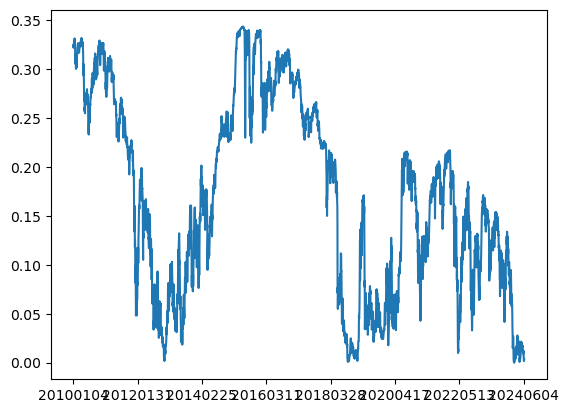

In [16]:
data.plot()

In [17]:
((data > data.rolling(5,closed = 'left').quantile(2/3)).loc['20210104':'20240101']).replace({True:1.0,False:0})

20210104    1.0
20210105    1.0
20210106    0.0
20210107    0.0
20210108    0.0
           ... 
20231225    0.0
20231226    0.0
20231227    0.0
20231228    1.0
20231229    1.0
Length: 727, dtype: float64

In [18]:
rolling_day = [5,10,20,50,100]

In [19]:
test_day_index = data.loc['20210104':'20240101'].index

In [20]:
data > data.rolling(30).quantile(0.7)

20100104    False
20100105    False
20100106    False
20100107    False
20100108    False
            ...  
20240604    False
20240605    False
20240606    False
20240607    False
20240611    False
Length: 3505, dtype: bool

In [21]:
feature['ILQ_type_raw'].quantile(1/5)

0.0